# Duration "what-if" simulation with empirical distributions 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)

In [3]:
def dump_quantiles(data):
    q = np.quantile(data, [0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    print(f"p25 = {q[0]}")
    print(f"p50 = {q[1]}")
    print(f"p75 = {q[2]}")
    print(f"p90 = {q[3]}")
    print(f"p95 = {q[4]}")
    print(f"p99 = {q[5]}")

## 1 Generate distributions 

Here we generate some "messy" distributions.

In [4]:
query_dist = np.concatenate((rng.lognormal(1.1, 0.8, 4500) + 35.3, rng.lognormal(1.2, 1.2, 15500) + 46.2))
np.random.shuffle(query_dist)

cpu_dist = np.concatenate((rng.lognormal(0.8, 1.2, 4500) + 30.8, rng.lognormal(1.4, 1.2, 15500) + 25.0))
np.random.shuffle(cpu_dist)

total_dist = query_dist + cpu_dist

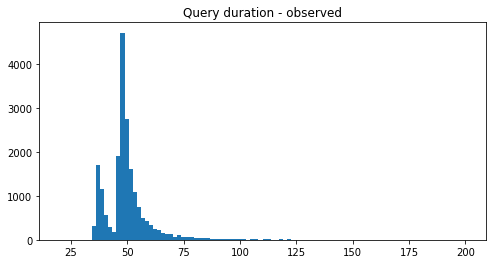

In [5]:
plt.figure(figsize=(8, 4))
plt.title("Query duration - observed")
plt.hist(query_dist, bins=100, range=[20, 200])
plt.show()

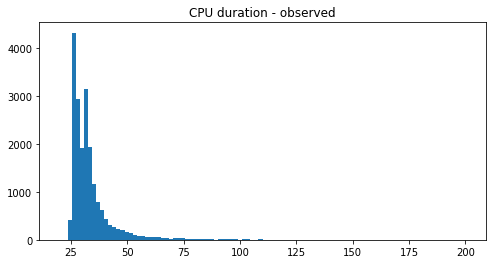

In [6]:
plt.figure(figsize=(8, 4))
plt.title("CPU duration - observed")
plt.hist(cpu_dist, bins=100, range=[20, 200])
plt.show()

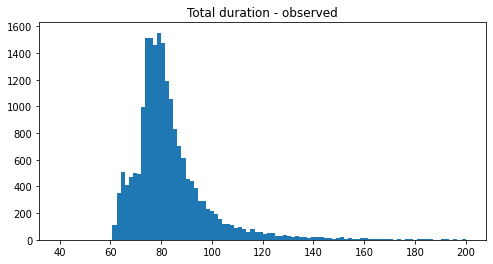

In [7]:
plt.figure(figsize=(8, 4))
plt.title("Total duration - observed")
plt.hist(total_dist, bins=100, range=[40, 200])
plt.show()

In [8]:
dump_quantiles(total_dist)

p25 = 74.84502214518488
p50 = 80.12306409547233
p75 = 87.66634820385954
p90 = 100.32414988548985
p95 = 113.06335828341636
p99 = 154.1028411052764


## 2 Sampling from an empirical distribution

In [9]:
num_bins = 1000
indices = np.arange(0, 1, 1.0 / num_bins)
query_quantiles = np.quantile(query_dist, indices)
cpu_quantiles = np.quantile(cpu_dist, indices)

In [10]:
cpu_dist = np.empty(20000)
for i in range(20000):
    cpu_dist[i] = cpu_quantiles[rng.integers(0, num_bins)]

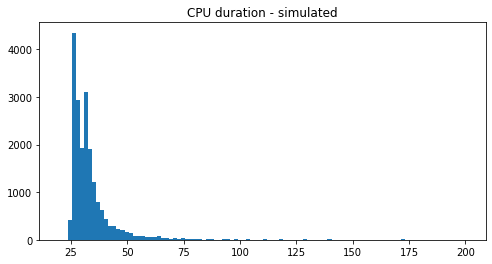

In [11]:
plt.figure(figsize=(8, 4))
plt.title("CPU duration - simulated")
plt.hist(cpu_dist, bins=100, range=[20, 200])
plt.show()

## 3 What-if analysis

In [12]:
def run_sim(n, query_factor, cpu_factor):
    dist = np.empty(n)
    for i in range(n):
        query_value = query_quantiles[rng.integers(0, num_bins)] * query_factor
        cpu_value = cpu_quantiles[rng.integers(0, num_bins)] * cpu_factor
        dist[i] = query_value + cpu_value
    return dist

### 3.1 Simulation - baseline

In [13]:
sim_dist_baseline = run_sim(20000, 1.0, 1.0)

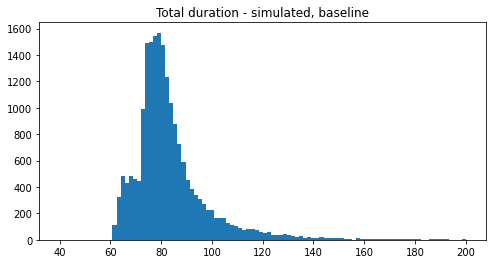

In [14]:
plt.figure(figsize=(8, 4))
plt.title("Total duration - simulated, baseline")
plt.hist(sim_dist_baseline, bins=100, range=[40, 200])
plt.show()

In [15]:
dump_quantiles(sim_dist_baseline)

p25 = 74.99298503936755
p50 = 80.19850860591995
p75 = 87.58637915887789
p90 = 100.97048228534271
p95 = 113.78425176849915
p99 = 150.02981501819426


### 3.2 Simulation - faster queries 

In [16]:
sim_dist_whatif_query = run_sim(20000, 0.8, 1.0)

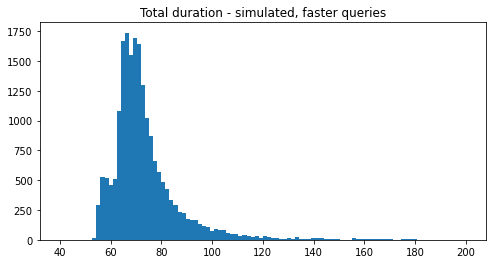

In [17]:
plt.figure(figsize=(8, 4))
plt.title("Total duration - simulated, faster queries")
plt.hist(sim_dist_whatif_query, bins=100, range=[40, 200])
plt.show()

In [18]:
dump_quantiles(sim_dist_whatif_query)

p25 = 65.53144937673622
p50 = 70.3478815058618
p75 = 77.02780401510302
p90 = 88.837088718723
p95 = 99.63046918459695
p99 = 134.3334638392895


### 3.3 Simulation - faster CPU 

In [19]:
sim_dist_whatif_cpu = run_sim(20000, 1.0, 0.8)

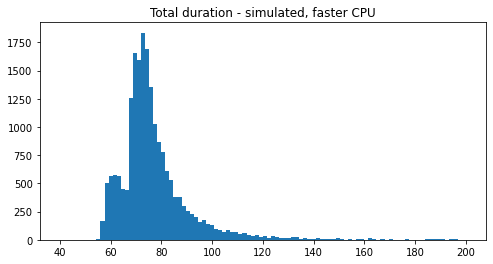

In [20]:
plt.figure(figsize=(8, 4))
plt.title("Total duration - simulated, faster CPU")
plt.hist(sim_dist_whatif_cpu, bins=100, range=[40, 200])
plt.show()

In [21]:
dump_quantiles(sim_dist_whatif_cpu)

p25 = 69.28530485462767
p50 = 73.94050992854321
p75 = 80.89674740205663
p90 = 92.59470987220512
p95 = 103.45867189744712
p99 = 136.4284014725134


### 3.4 Simulation - faster queries and CPU 

In [22]:
sim_dist_whatif_both = run_sim(20000, 0.8, 0.8)

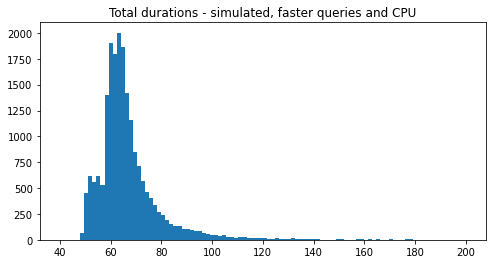

In [23]:
plt.figure(figsize=(8, 4))
plt.title("Total durations - simulated, faster queries and CPU")
plt.hist(sim_dist_whatif_both, bins=100, range=[40, 200])
plt.show()

In [24]:
dump_quantiles(sim_dist_whatif_both)

p25 = 59.846555981453164
p50 = 64.04193636456897
p75 = 69.9296221904291
p90 = 80.06733935445067
p95 = 90.16267111447996
p99 = 119.60618320482277
